# Lab 1: 'Singularity Machine Learning - Classification' by Multiverse Computing

Welcome to this hands-on lab exploring the power of the 'Singularity Machine Learning - Classification' function. In this session, you'll walk through a real-world machine learning task—grid stability classification—leveraging both classical and quantum-enhanced techniques. You'll gain experience using a hybrid workflow that seamlessly integrates scikit-learn preprocessing with quantum ensemble classifiers hosted on IBM's serverless infrastructure. Whether running simulations or real quantum hardware, this lab gives you a practical glimpse into how scalable quantum machine learning can accelerate real-world applications. Beyond just building models, the goal of this notebook is to familiarize you with the capabilities of the QuantumEnhancedEnsembleClassifier and help you develop intuition around its features and advantages. You'll begin by establishing a classical benchmark using AdaBoost, then proceed through three exercises that demonstrate key functionalities: running the quantum classifier with a simulated quantum backend, simulating a heterogeneous ensemble with diverse learners, and finally executing the classifier on real quantum hardware. Each step is designed to build your confidence with the tool and deepen your understanding of where and how quantum optimization can offer meaningful benefits. Let’s dive in!

# Table of Contents

* [Setup](#setup)
* [Imports](#imports)
* [Initialize the 'Singularity Machine Learning - Classification' Function](#initialize-the-singularity-machine-learning---classification-function)
    * [Set Static Variables and IBM Token](#set-static-variables-and-ibm-token)
    * [Load the 'Singularity Machine Learning - Classification' Function and Client](#load-the-singularity-machine-learning---classification-function-and-client)
* [Define Helper Functions](#define-helper-functions)
* [Load the Dataset](#load-the-dataset)
* [AdaBoostClassifier](#adaboostclassifier)
* [QuantumEnhancedEnsembleClassifier](#quantumenhancedensembleclassifier)
    * [Introduction](#introduction)
  * [Understanding the Optimization Parameters](#understanding-the-optimization-parameters)
* [Part 1: Simulated Quantum Classifier](#part-1-simulated-quantum-classifier)
    * [Execute the Job](#execute-the-job)
    * [Monitor Job Execution](#monitor-job-execution)
    * [Retrieve and Analyze the Results](#retrieve-and-analyze-the-results)
* [Part 2: Simulated Heterogenous Quantum Classifier](#part-2-simulated-heterogenous-quantum-classifier)
    * [Execute the Job](#execute-the-job)
    * [Monitor Job Execution](#monitor-job-execution)
    * [Retrieve and Analyze the Results](#retrieve-and-analyze-the-results)
* [Part 3: Quantum Classifier on Real Quantum Hardware](#part-3-quantum-classifier-on-real-quantum-hardware)
    * [Execute the Job](#execute-the-job)
    * [Monitor Job Execution](#monitor-job-execution)
    * [Retrieve and Analyze the Results](#retrieve-and-analyze-the-results)
    * [Visualization: Classical vs Quantum F1 Score](#visualization-classical-vs-quantum-f1-score)
* [Clean up Shared Directory](#clean-up-shared-directory)
* [Scaling Benefits and Enhancements](#scaling-benefits-and-enhancements)
* [References](#references)
* [Additional information](#additional-information)
* [Qiskit packages versions](#qiskit-packages-versions)


# Setup

In [1]:
# Install dependencies
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install "qiskit[visualization]~=2.1.0" "qiskit-serverless~=0.24.0" "qiskit-ibm-catalog~=0.8.0" "scikit-learn==1.5.2" "pandas>=2.0.0,<3.0.0" "imbalanced-learn~=0.12.3"

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-s3w0z1cm/qc-grader_a5cada56baa740028f66c6a75d89eb46
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-s3w0z1cm/qc-grader_a5cada56baa740028f66c6a75d89eb46
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 KB 935.4 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
import qc_grader

print(f"Grader version: {qc_grader.__version__}")

Grader version: 0.22.12


You should have Grader `>=0.22.11`. If you see a lower version, you need to restart your kernel and reinstall the grader.

In [6]:
# Imports

import sys
import os
import tarfile
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_serverless import IBMServerlessClient, QiskitFunction
from typing import Tuple
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from grader import grade_exercise_1, grade_exercise_2, grade_exercise_3
from qc_grader.challenges.qgss_2025 import grade_multiverse_function

<div class="alert alert-block alert-warning">

**Exclusive Access to Qiskit Functions**

As part of Qiskit Global Summer School (QGSS), participants with a Premium or Flex Plan have limited-time trial access to Qiskit Functions. Access is exclusive and subject to your organization’s administrator approval. Complete [this form](https://airtable.com/appj8IrSNZGz4l4BB/pag8WgWdUr5uSJGZA/form) to request access.

If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`. in the cell below, it means your access to Qiskit Functions is not yet active. Please check back later after your request has been processed.

**Note: Running this lab will consume QPU time from your organization’s account. Estimated QPU usage is provided before each cell that executes on a QPU. Please monitor your usage and consult your organization admin if you’re unsure about your allocated QPU time for QGSS Functions labs.**

</div>

# Initialize the 'Singularity Machine Learning - Classification' Function

We will start by initializing the IBM Qiskit Serverless client and retrieve the function from the Multiverse Computing workspace. Qiskit Serverless offers a flexible and scalable way to run Qiskit programs without worrying about the underlying infrastructure. It allows you to offload complex quantum-classical workflows to the cloud, automatically managing resources across CPUs, GPUs, and QPUs. This makes it easier to focus on your algorithm logic while benefiting from remote, managed execution on the IBM Quantum Platform.

By loading the 'Singularity Machine Learning - Classification' function, we gain access to a powerful quantum-enhanced classifier that can be used for hybrid workflows. This function encapsulates both classical and quantum components, allowing us to train, optimize, and predict with ensemble methods enhanced by quantum processing. For full details, please refer to our documentation: <https://docs.quantum.ibm.com/guides/multiverse-computing-singularity>.

Let’s get started by connecting to the serverless environment and loading the function.

In [ ]:
print("Using IBM Qiskit Serverless...\n")

# Load the IBM Serverless Client
your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

client = IBMServerlessClient(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)
# You should see a list of Qiskit Functions available to you
# If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`,
# it means your access is not yet active
client.list()

Using IBM Qiskit Serverless...



[QiskitFunction(qunova/hivqe-chemistry),
 QiskitFunction(global-data-quantum/quantum-portfolio-optimizer),
 QiskitFunction(algorithmiq/tem),
 QiskitFunction(qedma/qesem),
 QiskitFunction(multiverse/singularity),
 QiskitFunction(q-ctrl/optimization-solver),
 QiskitFunction(colibritd/quick-pde),
 QiskitFunction(q-ctrl/performance-management),
 QiskitFunction(kipu-quantum/iskay-quantum-optimizer)]

<div class="alert alert-block alert-success">
    
<b> Load Qiskit Function</b>

Find the correct function name from the list above, or refer to the [Qiskit Functions Catalog](https://quantum.cloud.ibm.com/functions) to locate the appropriate function name string. The name should follow the format: `"[provider]/[title]"`.

</div>

In [11]:
# Load the Multiverse Singularity function

function_name = "multiverse/singularity"  # TODO
singularity = client.get(function_name)

In [31]:
grade_multiverse_function(singularity)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Congratulations 🎉! Your answer is correct and has been submitted.


In [20]:
# Define static variables

RANDOM_STATE: int = 123
TRAIN_PATH = "data/grid_stability/train.csv"
TEST_PATH = "data/grid_stability/test.csv"

# Define Helper Functions

To streamline the workflow, we define a set of helper functions used for data handling and evaluation throughout this lab. These functions enable a smooth interface between local data processing and remote execution with Qiskit Serverless.

In [12]:
def load_data(data_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load data from the given path to X and y arrays."""
    df: pd.DataFrame = pd.read_csv(data_path)
    return df.iloc[:, :-1].values, df.iloc[:, -1].values


def make_tarfile(file_path, tar_file_name):
    """Create a tar file from the given file."""
    with tarfile.open(tar_file_name, "w") as tar:
        tar.add(file_path, arcname=os.path.basename(file_path))


def upload_data(name: str, data: np.ndarray, client: IBMServerlessClient, function: QiskitFunction):
    """Save the data to a file, create a tar file, upload it, and remove the files."""
    np.save(name, data)
    make_tarfile(name, f"{name}.tar")
    client.file_upload(f"{name}.tar", function)

    
def evaluate_predictions(predictions, y_true, start_time=None, end_time=None):
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    if start_time is not None and end_time is not None:
        print("Time taken (s):", end_time - start_time)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    return accuracy, precision, recall, f1

# Load the Dataset 

Next, we load and preprocess the dataset used for training and evaluating our quantum-enhanced classifier. The dataset consists of labeled samples for a grid stability classification task, where the goal is to predict system stability based on sensor inputs.

We begin by reading the training and test data from CSV files and then split the training set further to create a validation set. To address class imbalance—a common issue in real-world datasets—we apply random over-sampling to augment the minority class, ensuring that the classifier is not biased toward the dominant label.

Once prepared, the datasets are serialized as NumPy arrays and uploaded to the Qiskit Serverless environment. This allows the remote 'Singularity Machine Learning - Classification' function to access and operate on the data during distributed execution.

In [21]:
# Load and upload the data
X_train, y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)
# Balance the dataset through over-sampling of the positive class
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [32]:
print("-- Uploading data --")
upload_data("grid_stability_X_train.npy", X_train, client, singularity)
upload_data("grid_stability_y_train.npy", y_train, client, singularity)
upload_data("grid_stability_X_test.npy", X_test, client, singularity)
print("Data uploaded!\n")

-- Uploading data --
Data uploaded!

Data uploaded!



# AdaBoostClassifier

Now that the data is ready, let's begin by using the AdaBoostClassifier, a well-established ensemble method in classical machine learning. AdaBoost works by combining multiple weak learners into a single strong classifier, iteratively improving performance by focusing more on difficult-to-classify samples.

In this lab, we train the AdaBoost model using the balanced training set and evaluate it on the test set. This provides a strong baseline for comparison with the quantum-enhanced classifier we'll use later. The number of estimators is set to 75 to allow the ensemble to generalize well without overfitting.

After training, we generate predictions on the test set and compute key performance metrics—accuracy, precision, recall, and F1-score—to assess how well the model performs on this grid stability classification task.

In [34]:
classifier = AdaBoostClassifier(n_estimators=75, random_state=RANDOM_STATE)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [35]:
evaluate_predictions(predictions, y_test)

Accuracy: 0.7853333333333333
Precision: 1.0
Recall: 0.7853333333333333
F1: 0.8797610156833457


(0.7853333333333333, 1.0, 0.7853333333333333, 0.8797610156833457)

# QuantumEnhancedEnsembleClassifier

### Introduction

The `QuantumEnhancedEnsembleClassifier` is a hybrid machine learning model from Multiverse Computing's 'Singularity Machine Learning - Classification' Function, combining classical ensemble methods—like boosting and bagging—with quantum optimization algorithms such as QAOA. Unlike classical ensembles, which become increasingly expensive to train as the number of learners grows, this quantum classifier demonstrates favorable scalability properties: training time remains comparatively stable as the number of learners (and thus qubits) increases. This makes it especially well-suited for problems that require large ensembles—where classical models tend to struggle with optimization costs that scale exponentially. Additionally, unlike traditional quantum models such as QSVMs, which are often constrained by dataset size, this classifier is designed to operate independently of the number of data points and features—limited primarily by available hardware infrastructure—making it well-suited for processing large-scale, high-dimensional datasets. As quantum hardware scales, so too will the accuracy and performance of this model—offering a compelling trajectory for future real-world quantum advantage. In this notebook, we demonstrate its use in both classical simulation and real quantum execution, showcasing its potential and flexibility.

![Diagram](diagram.png)

---

## Understanding the Optimization Parameters

To effectively use the `QuantumEnhancedEnsembleClassifier`, it's important to understand the role of several key parameters that influence model training and optimization. Please refer to the [documentation](https://docs.quantum.ibm.com/guides/multiverse-computing-singularity) for details on the usage and parameters for this function. 

Some of the key parameters, also used in this lab, are explained below:

- **`regularization`**  
  This parameter controls the complexity of the final ensemble. A higher value penalizes large or complex learner combinations, promoting simpler models and reducing the risk of overfitting. 

- **`num_solutions`**  
  Defines the number of candidate ensemble configurations that the optimizer evaluates. Higher values lead to more exhaustive searches and can uncover better-performing ensembles, but at the cost of increased runtime. For demonstration, values around `100,000` balance exploration and performance.

- **`simulator`**  
  Setting this to `True` enables classical optimization—faster and well-suited for quick experimentation but does not benefit from the scalability advantages of quantum computation. Setting it to `False` activates quantum optimization via QAOA, ideal for larger ensembles.

- **`classical_optimizer_options`**  
  These options define the behavior of the underlying classical optimizer used in QAOA. For instance, `{"maxiter": 10}` limits the number of optimization iterations—useful for short demos, but convergence usually improves with `60+` iterations in real applications.

These parameters give you flexibility to balance speed, accuracy, and compute resource use. In the following sections, you'll experiment with both classical and quantum setups to see these trade-offs in action.


# Part 1: Simulated Quantum Classifier

### Execute the Job

Now let’s begin experimenting with the `QuantumEnhancedEnsembleClassifier` provided by the Singularity Qiskit Function. This classifier integrates classical ensemble learning with quantum-inspired optimization to intelligently combine multiple learners.

In this exercise, we configure the model to use classical optimization using our simulator. This allows you to test the optimization logic without invoking real quantum hardware. For demonstration purposes, we set `num_learners` to `15`, which controls how many weak learners the ensemble will combine. Note that the simulator mode is not designed for scalability—larger values of `num_learners` may significantly increase runtime or hit performance limits.

This setup provides a quick, low-cost way to validate the workflow and gain insights into the expected performance before scaling up with quantum optimization.


<div class="alert alert-block alert-success">
  <strong>Exercise 1:</strong>  
  Fill in the <code>#TODO</code> sections to enable the simulator for classical optimization.
</div>

<div class="alert alert-block alert-info">
  <strong>💡 Tip:</strong> Refer to the documentation 
  <a href="https://docs.quantum.ibm.com/guides/multiverse-computing-singularity" target="_blank">here</a> on how to enable the simulator.
</div>

<div class="alert alert-block alert-warning">
  <strong>⚠️ Warning:</strong> Use a simulator for this exercise to avoid consuming QPU time.
</div>

In [14]:
optimizer_options_ex1 = {
    ### TODO: Write your code below here ###
    "simulator": True,
    ### Don't change any code past this line ###
    "num_solutions": 100000,
}

In [15]:
grade_exercise_1(optimizer_options_ex1)

✅ Exercise 1 solution is correct!


In [16]:
# Create, fit, and predict
print("-- Creating, fitting, and predicting --")
start = time.time()
job = singularity.run(
    action="create_fit_predict",
    name="classifier_for_grid_stability",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=15, 
    regularization=15,
    optimizer_options=optimizer_options_ex1,
    backend_name= None, 
    instance=your_crn,
    random_state=RANDOM_STATE,
    X_train="grid_stability_X_train.npy",
    y_train="grid_stability_y_train.npy",
    X_test="grid_stability_X_test.npy",
    fit_params={
        "validation_data": (X_val, y_val),
    },
    options={
        "save": False,
    }
)

-- Creating, fitting, and predicting --


### Monitor Job Execution

Now that the job has been submitted, we can print `job` to save the JobID, and monitor the status of the execution using `job.status()`. The cell can be re-ran again to ping for the latest status. If the job fails, we can obtain information about the reason it did so using `job.error_message()`. 



In [17]:
job

<Job | 3adb5e46-aa3e-4d0c-8bb6-76787dd9cda1>

In [30]:
job.status()

'DONE'

In [19]:
error_message = job.error_message()
print(error_message)

### Retrieve and Analyze the Results

Once the job has been submitted and completed, we can retrieve the results using `job.result()`. We can then evaluate the results using our previously defined helper function and ensure it matches our expectation.

In [31]:
# Get the job status, logs, and result
result = job.result()
status = job.status()
error_message = job.error_message()
end = time.time()

print("Job status: ", status)
print("Error message: ", error_message)
print("Action status: ", result["status"])
print("Action message: ", result["message"])
print("Action result: ", result["data"])

Job status:  DONE
Error message:  
Action status:  ok
Action message:  Classifier created, fitted, and predicted.
Action result:  {'predictions': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0

In [32]:
predictions = result["data"]["predictions"]
evaluate_predictions(predictions, y_test, start, end)

Time taken (s): 389.6062481403351
Accuracy: 0.8693333333333333
Precision: 1.0
Recall: 0.8693333333333333
F1: 0.9300998573466477


(0.8693333333333333,
 np.float64(1.0),
 np.float64(0.8693333333333333),
 np.float64(0.9300998573466477))

# Part 2: Simulated Heterogenous Quantum Classifier

### Execute the Job

In this section, we simulate a heterogeneous quantum ensemble using classical resources. Unlike the standard simulated classifier, the heterogeneous variant allows us to define a mix of different learner types within the ensemble—such as decision trees, k-nearest neighbors, or logistic regression—each contributing a unique inductive bias. This strategy can enhance model diversity and improve generalization, particularly on complex datasets with varied feature relationships.

<div class="alert alert-block alert-success">
  <strong>Exercise 2:</strong>  
  Fill in the <code>#TODO</code> sections to create a job that uses two unique learners, with an equal proportion distributed between them. 
</div>

<div class="alert alert-block alert-info">
  <strong>💡 Tip:</strong> Refer to the documentation 
  <a href="https://docs.quantum.ibm.com/guides/multiverse-computing-singularity" target="_blank">here</a> on how to specify different learners. Observe how this influenced the results. Once you have passed the exercise grader, feel free to experiment with different learners to learn how this impacts the performance.
</div>

In [33]:
### TODO: Write your code below here ###
learners_types_solution = [
        "DecisionTreeClassifier",
        "KNeighborsClassifier",
]
learners_proportions_solution = [0.5 , 0.5]
### Don't change any code past this line ###

In [34]:
grade_exercise_2(learners_types_solution, learners_proportions_solution)

✅ Exercise 2 solution is correct!


<div class="alert alert-block alert-warning">
  <strong>⚠️ Warning:</strong> Note that for this exercise, we again use a simulator to avoid consuming QPU time.
</div>

In [35]:
# Create, fit, and predict
print("-- Creating, fitting, and predicting --")
start = time.time()
job = singularity.run(
    action="create_fit_predict",
    name="classifier_for_grid_stability",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=15, 
    regularization=15,
    learners_types=learners_types_solution,
    learners_proportions=learners_proportions_solution,
    optimizer_options={
        "num_solutions": 100000,
        "simulator": True, 
    },
    backend_name= None, 
    instance=your_crn,
    random_state=RANDOM_STATE,
    X_train="grid_stability_X_train.npy",
    y_train="grid_stability_y_train.npy",
    X_test="grid_stability_X_test.npy",
    fit_params={
        "validation_data": (X_val, y_val),
    },
    options={
        "save": False,
    }
)

-- Creating, fitting, and predicting --


### Monitor Job Execution

Now that the job has been submitted, we can print `job` to save the JobID, and monitor the status of the execution using `job.status()`. The cell can be re-ran again to ping for the latest status. If the job fails, we can obtain information about the reason it did so using `job.error_message()`. 

In [36]:
job

<Job | 0bebf504-a850-4a80-a73a-2ea32d373ab0>

In [41]:
job.status()

'DONE'

In [42]:
error_message = job.error_message()
print(error_message)

### Retrieve and Analyze the Results

Once the job has been submitted and completed, we can retrieve the results using `job.result()`. We can then evaluate the results using our previously defined helper function and ensure it matches our expectation.

In [43]:
# Get the job status, error affecting the job (if any), and result
result = job.result()
status = job.status()
error_message = job.error_message()
end = time.time()

print("Job status: ", status)
print("Error message: ", error_message)
print("Action status: ", result["status"])
print("Action message: ", result["message"])
print("Action result: ", result["data"])

Job status:  DONE
Error message:  
Action status:  ok
Action message:  Classifier created, fitted, and predicted.
Action result:  {'predictions': [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1

In [44]:
predictions = result["data"]["predictions"]
evaluate_predictions(predictions, y_test, start, end)

Time taken (s): 402.3746497631073
Accuracy: 0.616
Precision: 1.0
Recall: 0.616
F1: 0.7623762376237624


(0.616, np.float64(1.0), np.float64(0.616), np.float64(0.7623762376237624))

# Part 3: Quantum Classifier on Real Quantum Hardware

### Execute the Job

Next, let's use real quantum hardware to perform the evaluation. This approach offers multiple advantages, the most significant being better scalability as the number of learners increases. Unlike the simulator mode, which uses classical resources, real quantum optimization can efficiently handle larger ensembles and more complex search spaces.

To enable quantum optimization, set the `simulator` flag to `False` in the `optimizer_options`. Also include a `classical_optimizer_options` parameter to control the convergence behavior. While quantum algorithms like QAOA generally benefit from `maxiter` values of 60 or more, for demonstration purposes we limit it to `10` to ensure shorter runtimes—approximately 10 minutes is expected.

This section showcases how hybrid quantum-classical workflows can be executed at scale using Qiskit Serverless, bridging the gap between research and production-ready quantum applications.


<div class="alert alert-block alert-success">
  <strong>Exercise 3:</strong>  
  Fill in the <code>#TODO</code> sections to specify the optimizer options, for a job that runs the <code>QuantumEnhancedEnsembleClassifier</code> on real quantum hardware. Limit the number of iterations in the optimization to <code>10</code> to ensure it finishes in a reasonable amount of time (expected: ~10 minutes).
</div>

<div class="alert alert-block alert-info">
  <strong>💡 Tip:</strong> Use a similar configuration as the one used in <em>Part 1: Simulated Quantum Classifier</em>. Once you have passed the exercise, feel free to experiment with different parameters such as <code>regularization</code>, <code>num_learners</code>, or <code>num_solutions</code> to explore how they influence performance and optimization time. Refer to the documentation 
  <a href="https://docs.quantum.ibm.com/guides/multiverse-computing-singularity" target="_blank">here</a> for examples.
</div>

In [53]:
optimizer_options_ex3 = {
    ### TODO: Write your code below here ###
    "simulator": False,
    "num_learners": 10,
    "num_solutions": 100000,
    "classical_optimizer_options": {
        "maxiter": 10,
    }
    ### Don't change any code past this line ###
}

In [54]:
grade_exercise_3(optimizer_options_ex3)

✅ Exercise 3 solution is correct!


<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit a job to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 2 minutes 47 seconds (based on tests on `ibm_brisbane`)

</div>

In [55]:
# Create, fit, and predict
print("-- Creating, fitting, and predicting --")
start = time.time()
job = singularity.run(
    action="create_fit_predict",
    name="classifier_for_grid_stability",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=75,
    regularization=15,
    optimizer_options=optimizer_options_ex3,
    backend_name=None,
    instance=your_crn,
    random_state=RANDOM_STATE,
    X_train="grid_stability_X_train.npy",
    y_train="grid_stability_y_train.npy",
    X_test="grid_stability_X_test.npy",
    fit_params={
        "validation_data": (X_val, y_val),
    },
    options={
        "save": False,
    }
)

-- Creating, fitting, and predicting --


### Monitor Job Execution

Now that the job has been submitted, we can print `job` to save the JobID, and monitor the status of the execution using `job.status()`. The cell can be re-ran again to ping for the latest status. If the job fails, we can obtain information about the reason it did so using `job.error_message()`. 

In [56]:
job

<Job | 4b10bc6d-be8d-43cc-afbb-d1101294afd7>

In [14]:
#used to retrieve the job status using the job ID
job_id = "4b10bc6d-be8d-43cc-afbb-d1101294afd7"
job = client.job(job_id)

In [15]:
job.status()

'DONE'

In [16]:
error_message = job.error_message()
print(error_message)

### Retrieve and Analyze the Results

Once the job has been submitted and completed, we can retrieve the results using `job.result()`. We can then evaluate the results using our previously defined helper function and ensure it matches our expectation.

In [36]:
# Get the job status, logs, and result
result = job.result()
status = job.status()
error_message = job.error_message()
end = time.time()

print("Job status: ", status)
print("Error message: ", error_message)
print("Action status: ", result["status"])
print("Action message: ", result["message"])
print("Action result: ", result["data"])

Job status:  DONE
Error message:  
Action status:  ok
Action message:  Classifier created, fitted, and predicted.
Action result:  {'predictions': [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1

In [37]:
#cell used because i closed the notebook and lost the start and end variables
import datetime

start = datetime.datetime(2025, 7, 24, 23, 25).timestamp()
end = datetime.datetime(2025, 7, 25, 1, 7).timestamp()

In [38]:
predictions = result["data"]["predictions"]
evaluate_predictions(predictions, y_test, start, end)

Time taken (s): 6120.0
Accuracy: 0.92
Precision: 1.0
Recall: 0.92
F1: 0.9583333333333334


(0.92, 1.0, 0.92, 0.9583333333333334)

### Visualization: Classical vs Quantum F1 Score

To summarize our experiments, let’s compare the F1 scores of the classical and quantum classifiers. F1 score is a balanced metric that considers both precision and recall, making it especially useful in imbalanced classification tasks like this one. This visualization helps highlight the performance gains introduced by quantum optimization.

Accuracy: 0.7853333333333333
Precision: 1.0
Recall: 0.7853333333333333
F1: 0.8797610156833457
Accuracy: 0.92
Precision: 1.0
Recall: 0.92
F1: 0.9583333333333334


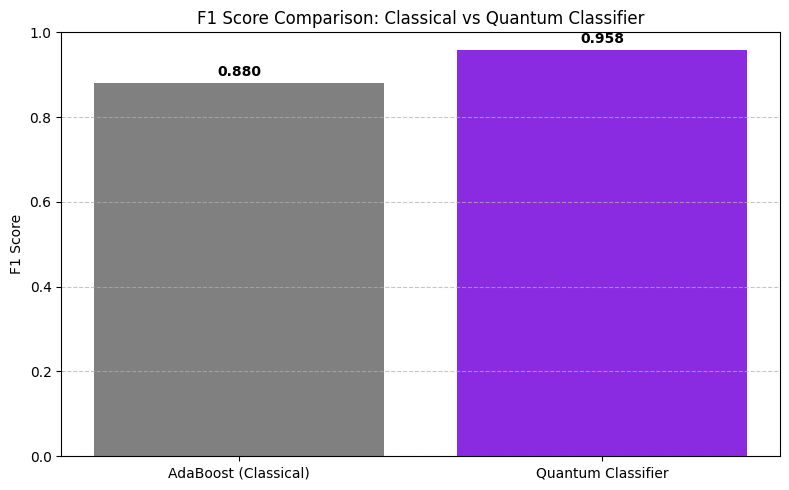

In [39]:
# Collect F1 scores from both experiments
labels = ["AdaBoost (Classical)", "Quantum Classifier"]
f1_scores = []

# Recalculate F1 for AdaBoost
_, _, _, f1_ada = evaluate_predictions(classifier.predict(X_test), y_test)
f1_scores.append(f1_ada)

# Use F1 score from the quantum job
_, _, _, f1_quantum = evaluate_predictions(predictions, y_test)
f1_scores.append(f1_quantum)

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, f1_scores, color=["#808080", "#8A2BE2"])
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison: Classical vs Quantum Classifier")
plt.ylim(0, 1.0)
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1 + 0.01, f"{f1:.3f}", ha='center', va='bottom', fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Clean up Shared Directory

After completing all remote executions, it's important to clean up any temporary files that were uploaded to the Qiskit Serverless environment. This helps maintain a tidy workspace and avoids unnecessary storage usage in shared or limited environments.

In this step, we remove the uploaded `.tar` archives corresponding to the training and test datasets using the `client.file_delete()` method. These files are no longer needed after the jobs have completed and results have been retrieved.

Cleaning up is a good practice, especially when working with multiple users or when automating workflows in production.

In [40]:
# Clean up the shared data directory
file_names = [
    "grid_stability_X_train.npy",
    "grid_stability_y_train.npy",
    "grid_stability_X_test.npy",
]

for name in file_names:
    tar_name = f"{name}.tar"
    client.file_delete(tar_name, singularity)
    if os.path.exists(name):
        os.remove(name)
    if os.path.exists(tar_name):
        os.remove(tar_name)

# Scaling Benefits and Enhancements

The true power of the `QuantumEnhancedEnsembleClassifier` comes into play in scenarios that involve **large ensemble sizes** or **high-dimensional optimization**. While in this lab we limited the number of learners and iterations (`maxiter = 10`) to ensure the job completes in under 30 minutes, it's important to note that quantum optimization algorithms like QAOA typically require 60 or more iterations to converge effectively. This setting provides only a glimpse of the potential performance gains.

In classical ensemble optimization, the training time scales poorly—often exponentially—as the number of learners increases. This makes it impractical for large ensemble configurations due to the combinatorial nature of selecting optimal learners. On the other hand, quantum optimization is expected to scale much more favorably as you increase the number of learners or the problem size (e.g., qubits). In practice, this means quantum methods can remain efficient even when classical methods become infeasible.

# Feedback Survey

We’d love to hear about your experience using the Qiskit Function! Your feedback is valuable and will help Qiskit Function providers enhance their tools and services. Please take a moment to share your thoughts by completing our short 2 min [feedback survey](https://airtable.com/app6VujlNUHZuOnAF/pagpw6TgP9UEt4TAT/form).

# References

1. Qiskit Function:
   - [Qiskit Function Tutorial](https://docs.quantum.ibm.com/guides/functions)
   - [Qiskit Serverless Documentation](https://qiskit.github.io/qiskit-serverless/index.html)

2. Papers:
   - [Neven et al. 2008: Training a Binary Classifier with the Quantum Adiabatic Algorithm](https://arxiv.org/abs/0811.0416)
   - [Neven et al. 2012: QBoost: Large Scale Classifier Training with Adiabatic Quantum Optimization](http://proceedings.mlr.press/v25/neven12/neven12.pdf)


# Additional information

**Created by:** Sepehr Hosseini, Pablo Lauret

**Advised by:** Junye Huang

**Version:** 1.1.0

# Qiskit packages versions

In [41]:
import qiskit
import qiskit_serverless
import qiskit_ibm_catalog

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Serverless: {qiskit_serverless.__version__}')
print(f'Qiskit IBM Catalog: {qiskit_ibm_catalog.__version__}')

Qiskit: 2.1.1
Qiskit Serverless: 0.24.0
Qiskit IBM Catalog: 0.8.0
